In [2]:
# Import Libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from utils.plot_callback import PlotPredictionsCallback_log


## Prepare Data for Regression Analysis

In [3]:
# Load data
train_data = pd.read_csv("../Data_processing/Data_Splitting/2005_2024/All_prefecture_Housing_training_data.csv")
dev_data = pd.read_csv("../Data_processing/Data_Splitting/2005_2024/All_prefecture_Housing_dev_data.csv")

# Remove properties for which the price was less than 100,000 yen (~600 euros)
train_data_filtered = train_data[train_data["TotalTransactionValue"] >= 1e5].copy()
dev_data_filtered = dev_data[dev_data["TotalTransactionValue"] >= 1e5].copy()

# --- Prefecture soft encoding ---
national_avg_price = train_data_filtered["TotalTransactionValue"].mean()
prefecture_avg = train_data_filtered.groupby("Prefecture")["TotalTransactionValue"].mean()
prefecture_diff = prefecture_avg - national_avg_price
max_abs_diff = np.abs(prefecture_diff).max()
prefecture_soft_encoding = (prefecture_diff / max_abs_diff).clip(-1, 1)

train_data_filtered["PrefectureSoftEncoded"] = train_data_filtered["Prefecture"].map(prefecture_soft_encoding)
dev_data_filtered["PrefectureSoftEncoded"] = dev_data_filtered["Prefecture"].map(prefecture_soft_encoding)

# --- Year normalization ---
year_min = train_data_filtered["Year"].min()
year_max = train_data_filtered["Year"].max()
construction_min = train_data_filtered["ConstructionYear"].min()
construction_max = train_data_filtered["ConstructionYear"].max()

def normalize(col, col_min, col_max):
    return (col - col_min) / (col_max - col_min)

train_data_filtered["YearNormalized"] = normalize(train_data_filtered["Year"], year_min, year_max)
train_data_filtered["ConstructionYearNormalized"] = normalize(train_data_filtered["ConstructionYear"], construction_min, construction_max)
dev_data_filtered["YearNormalized"] = normalize(dev_data_filtered["Year"], year_min, year_max)
dev_data_filtered["ConstructionYearNormalized"] = normalize(dev_data_filtered["ConstructionYear"], construction_min, construction_max)

# --- Normalize the other continuous numeric features ---
features_to_normalize = [
    "Area", 
    "Frontage", 
    "TotalFloorArea", 
    "BuildingCoverageRatio", 
    "FloorAreaRatio",
    "AverageTimeToStation"
]

# Compute min/max for each feature in training set
normalization_params = {
    feature: (train_data_filtered[feature].min(), train_data_filtered[feature].max())
    for feature in features_to_normalize
}

# Apply normalization to both train and dev
for feature in features_to_normalize:
    f_min, f_max = normalization_params[feature]
    train_data_filtered[feature + "_Normalized"] = normalize(train_data_filtered[feature], f_min, f_max)
    dev_data_filtered[feature + "_Normalized"] = normalize(dev_data_filtered[feature], f_min, f_max)


# Encode Quarter as cyclic features
train_data_filtered["Quarter_Sin"] = np.round(np.sin(2 * np.pi * train_data_filtered["Quarter"] / 4), 10)
train_data_filtered["Quarter_Cos"] = np.round(np.cos(2 * np.pi * train_data_filtered["Quarter"] / 4), 10)

dev_data_filtered["Quarter_Sin"] = np.round(np.sin(2 * np.pi * dev_data_filtered["Quarter"] / 4), 10)
dev_data_filtered["Quarter_Cos"] = np.round(np.cos(2 * np.pi * dev_data_filtered["Quarter"] / 4), 10)

# Remove unwanted col.
# Note: Housing prices for properties in Japan quite constant over this time period. Removing them does not effect NN performance signficantly.
cols_to_exclude = [
    "Type", "Prefecture", "Location", "Year", "ConstructionYear", "YearNormalized", "Quarter"
] + features_to_normalize  # dropping original versions of normalized features

train_data_filtered.drop(columns=cols_to_exclude, inplace=True)
dev_data_filtered.drop(columns=cols_to_exclude, inplace=True)

# Quick Inspection
train_data_filtered.info()
train_data_filtered.head()



<class 'pandas.core.frame.DataFrame'>
Index: 1070812 entries, 0 to 1071316
Data columns (total 28 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   TotalTransactionValue             1070812 non-null  int64  
 1   RegionCommercialArea              1070812 non-null  bool   
 2   RegionIndustrialArea              1070812 non-null  bool   
 3   RegionPotentialResidentialArea    1070812 non-null  bool   
 4   RegionResidentialArea             1070812 non-null  bool   
 5   MunicipalityCategory              1070812 non-null  int64  
 6   Region_Chubu                      1070812 non-null  bool   
 7   FloorAreaGreaterFLag              1070812 non-null  bool   
 8   BeforeWarFlag                     1070812 non-null  bool   
 9   frontage_greater_than_50          1070812 non-null  bool   
 10  AreaGreaterFlag                   1070812 non-null  bool   
 11  Region_Chugoku                    1070812 

,TotalTransactionValue,RegionCommercialArea,RegionIndustrialArea,RegionPotentialResidentialArea,RegionResidentialArea,MunicipalityCategory,Region_Chubu,FloorAreaGreaterFLag,BeforeWarFlag,frontage_greater_than_50,...,PrefectureSoftEncoded,ConstructionYearNormalized,Area_Normalized,Frontage_Normalized,TotalFloorArea_Normalized,BuildingCoverageRatio_Normalized,FloorAreaRatio_Normalized,AverageTimeToStation_Normalized,Quarter_Sin,Quarter_Cos
0,21000000,False,False,False,True,4,False,False,False,False,...,-0.396710,0.7000,0.047739,0.114919,0.080402,1.0,0.200,0.058333,1.0,0.0
1,410000000,True,False,False,False,4,False,False,False,True,...,-0.084481,0.6375,1.000000,1.000000,0.698492,0.6,0.120,0.625000,-1.0,-0.0
2,29000000,False,False,False,True,3,False,False,False,False,...,-0.347627,0.9500,0.120603,0.254032,0.047739,0.6,0.040,0.375000,1.0,0.0
3,34000000,False,False,False,True,3,False,False,False,False,...,1.000000,0.8375,0.062814,0.044355,0.035176,0.0,0.008,0.216667,0.0,-1.0
4,28000000,False,False,False,True,3,False,False,False,False,...,0.043087,0.7875,0.045226,0.502016,0.045226,0.6,0.120,0.175000,0.0,-1.0


In [4]:
train_target = train_data_filtered['TotalTransactionValue'].values.astype(np.float32)
dev_target = dev_data_filtered['TotalTransactionValue'].values.astype(np.float32)

# Since the target value is highly skewed and spans multiple orders of magnitude, log-transform it.
train_target_log = np.log10(train_target + 1)
dev_target_log = np.log10(dev_target + 1)

# Extract features (without the target)
train_features_filtered = train_data_filtered.drop('TotalTransactionValue', axis=1).values.astype(np.float32)
dev_features_filtered = dev_data_filtered.drop('TotalTransactionValue', axis=1).values.astype(np.float32)


#normalizer = tf.keras.layers.Normalization(axis=-1)
#normalizer.adapt(train_features_filtered)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(train_features_filtered.shape[1],)),
 #   normalizer,
    tf.keras.layers.Dense(512),
    tf.keras.layers.ReLU(),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256),
    tf.keras.layers.ReLU(),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128),
    tf.keras.layers.ReLU(),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])

# Learning rate schedule for exponential decay.
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=0.005, 
#    decay_steps=300000, #Approximately every 10 epochs
#    decay_rate=0.99, 
#    staircase=True
#)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='mae')

# Model summary
model.summary()

/home/linuxbrew/.linuxbrew/Cellar/python@3.10/3.10.8/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2025-05-20 21:33:13.530358: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,689 (698.00 KB)

 Trainable params: 178,689 (698.00 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
plot_callback = PlotPredictionsCallback_log(dev_features_filtered, dev_target_log)
history = model.fit(
    train_features_filtered, train_target_log, 
    epochs=250, 
    batch_size=256, 
    validation_data=(dev_features_filtered, dev_target_log),
    callbacks=[plot_callback]
     )

# Get training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']


Epoch 1/250
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 3s 641us/step
4183/4183 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 0.2737 - val_loss: 0.1608
Epoch 2/250
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 3s 660us/step
4183/4183 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 0.1701 - val_loss: 0.1598
Epoch 3/250
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 3s 704us/step
4183/4183 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 0.1646 - val_loss: 0.1559
Epoch 4/250
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 3s 674us/step
4183/4183 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 0.1603 - val_loss: 0.1550
Epoch 5/250
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 3s 606us/step
4183/4183 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.1591 - val_loss: 0.1632
Epoch 6/250
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 3s 790us/step
4183/4183 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.1586 - val_loss: 0.1607
Epoch 7/250
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 3s 722us/step
4183/4183 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.1572 - val_loss: 0.1543
Epoch 8/250
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 3s 718us/ste

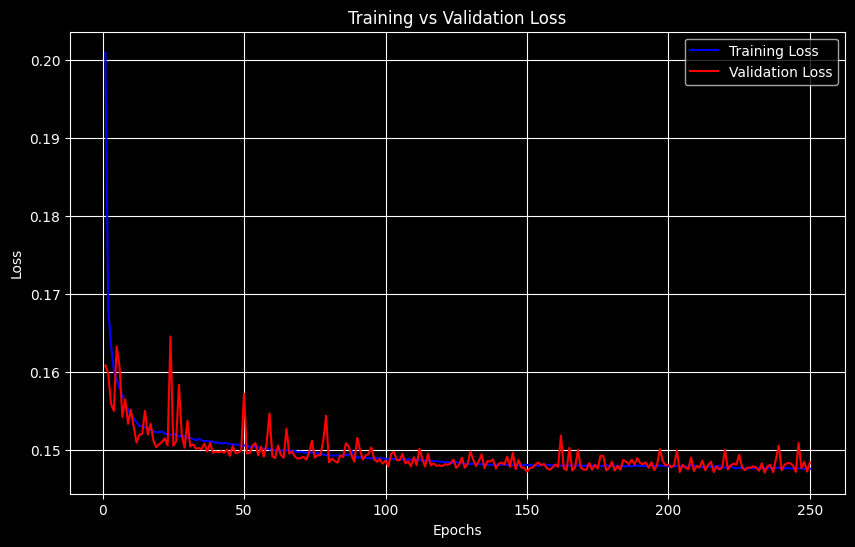

In [7]:
plt.figure(figsize=(10, 6))
plt.style.use('dark_background')
plt.plot(range(1, 251), train_loss, label='Training Loss', color='blue')
plt.plot(range(1, 251), val_loss, label='Validation Loss', color='red')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0,100)
#plt.xscale("log")
#plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
#Save model and weights
model.save('Japanese_Housing_Price_Model.keras')

model.save_weights('Japanese_Housing_Price_Model_epoch250.weights.h5')

## Evaluation on Test Set

Process Test data set in the exact same way as for the train and dev sets

In [27]:
# Load test set
test_data = pd.read_csv("../Data_processing/Data_Splitting/2005_2024/All_prefecture_Housing_test_data.csv")

# --- Same preprocessing as before ---
# Apply same filtering
test_data_filtered = test_data[test_data["TotalTransactionValue"] >= 1e5].copy()

# Prefecture soft encoding
test_data_filtered["PrefectureSoftEncoded"] = test_data_filtered["Prefecture"].map(prefecture_soft_encoding)

# Normalize Year and ConstructionYear using training min/max
test_data_filtered["YearNormalized"] = normalize(test_data_filtered["Year"], year_min, year_max)
test_data_filtered["ConstructionYearNormalized"] = normalize(test_data_filtered["ConstructionYear"], construction_min, construction_max)

# Normalize other features using training min/max as before
for feature in features_to_normalize:
    f_min, f_max = normalization_params[feature]
    test_data_filtered[feature + "_Normalized"] = normalize(test_data_filtered[feature], f_min, f_max)

# Encode Quarter as cyclic features
test_data_filtered["Quarter_Sin"] = np.round(np.sin(2 * np.pi * test_data_filtered["Quarter"] / 4), 10)
test_data_filtered["Quarter_Cos"] = np.round(np.cos(2 * np.pi * test_data_filtered["Quarter"] / 4), 10)

# Drop unwanted columns
test_data_filtered.drop(columns=cols_to_exclude, inplace=True)

# Prepare inputs and target
test_target = test_data_filtered['TotalTransactionValue'].values.astype(np.float32)
test_target_log = np.log10(test_target + 1)
test_features_filtered = test_data_filtered.drop('TotalTransactionValue', axis=1).values.astype(np.float32)


In [34]:
# Load the model
model = tf.keras.models.load_model('Japanese_Housing_Price_Model.keras')

# Evaluate
test_loss = model.evaluate(test_features_filtered, test_target_log, verbose=2)
print(f"Test Set MAE (log-transformed): {test_loss:.4f}")

4184/4184 - 4s - 845us/step - loss: 0.1490
Test Set MAE (log-transformed): 0.1490


4184/4184 ━━━━━━━━━━━━━━━━━━━━ 3s 639us/step


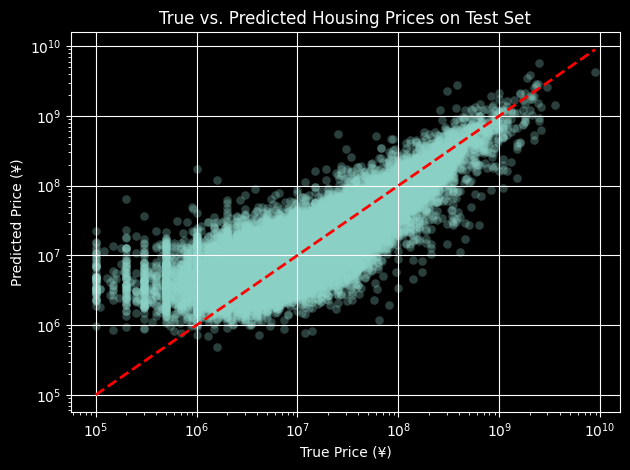

In [33]:
# Predict (if not already done)
y_pred_log = model.predict(test_features_filtered).flatten()
y_pred = np.power(10, y_pred_log) - 1  # Inverse of log10(x + 1)

# Ground truth
y_true = test_target

# Scatter plot
plt.scatter(y_true, y_pred, alpha=0.3, linewidths=0.1)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel("True Price (¥)")
plt.ylabel("Predicted Price (¥)")
plt.title("True vs. Predicted Housing Prices on Test Set")
plt.grid(True)
plt.xscale("log")
plt.yscale("log")
plt.tight_layout()
plt.show()